# Homework 4

### Costa Rican Household Poverty Level Prediction (Kaggle Competition)

#### By: Spencer Wise

The goal of the Costa Rican Household Poverty Level Prediction contest is to develop a machine learning model that can predict the poverty level of households using both individual and household characteristics. Many social programs have a hard time making sure the right people are given the right amount of aid, and it’s especially tricky when a program focuses on the poorest segment of the population. The world’s poorest typically can’t provide the necessary income and expense records to prove that they qualify.  Costa Rica is just one of many countries that faces this same problem of assessing social need.

In this notebook, we will do our best to come up with a complete machine learning solution to this problem. First, we will get introduced to the problem, then explore the dataset, clean the dataset, work on feature engineering, try out multiple machine learning models, optimize the models, and finally, inspect the outputs of the model and draw conclusions.

### Data Overview and Problem

The data for this competition is provided in a training set file and a test set file: `train.csv` and `test.csv`. The training set has 9557 rows and 143 columns, and the testing set has 23856 rows and 142 columns. Each row represents one individual and each column is a feature, either unique to the individual, or for the household of that individual. The training set has one additional column, `Target`, which represents the poverty level on a scale from 1-4. A value of 1 is the most extreme poverty, while a value of 4 represents non vulnerable households. This is a multi-class classification machine learning problem with 4 classes.

### Objective

The objective is to predict poverty on a household level. We are given data on the individual level with each individual having unique features but also information about their household. In order to create a dataset for the task, we'll have to perform some aggregations of the individual data for each household because according to the competition page, "ONLY the heads of household are used in scoring" which means we want to predict poverty on a household basis.

To begin, let's start by importing the necessary packages and reading in the data!

### Module Imports
We'll use a familiar stack of data science libraries: `Pandas` , `numpy`, `matplotlib`, `seaborn`, and `sklearn` for modeling. We'll also bring in `imblearn` to handle some imbalanced data later on.

In [1]:
# Pandas for data loading, manipulation etc.
import pandas as pd

# Numeric functions
import numpy as np
from scipy import stats
from scipy.stats import norm
from collections import OrderedDict

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modeling
from sklearn.linear_model import SGDRegressor, ElasticNetCV, LogisticRegression
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier

# Imbalanced data
from imblearn.over_sampling import RandomOverSampler

# Ignore deprication warnings
import warnings
warnings.filterwarnings('ignore')

### Load Data

Here we are going to first load the training and test datasets into pandas dataframes.

In [2]:
# Loading datasets into separate pandas dataframes
train = pd.read_csv(r"C:\Users\Spencer\Dropbox\School\Fall 2018\Machine Learning\Projects\Homework_4\train.csv", encoding="latin1")
test = pd.read_csv(r"C:\Users\Spencer\Dropbox\School\Fall 2018\Machine Learning\Projects\Homework_4\test.csv", encoding="latin1")

In [3]:
# Print the shape of the test and training datasets
print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


One interesting thing to note right off the bat is that the training dataset has one more column than the test dataset. That is because the train dataset includes our target value). Let's take a closer look by previewing our training data.

In [4]:
# Preview the data
pd.options.display.max_columns = 150
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


As we look at the above training data, we can see that we have a mix of variables that are mostly integers (130), some floats (8), and a handful of categorical variables (5). 

These are useful things to know because we now know that we will need to replace those categorical variables to dummy variables before we can model. 

## Learn the Data

Now that we've read in our data and have a basic idea of the shape of our dataset, we'll want to learn as much as we can about the data. The things that we will focus on in this section are:

- Knowing which variables are the core variables in the dataset
- Knowing the rest of the variables in the dataset
- Knowing if there are missing variables

**Core Data**

Because the data contains 142 total variables, we'll focus on learning as much as we can about the core data fields outlined by the Inter-American Development Bank. The core variables are:

- `Id`: a unique identifier for each row.
- `Target`: the target is an ordinal variable indicating groups of income levels. 
    - 1 = extreme poverty 
    - 2 = moderate poverty 
    - 3 = vulnerable households 
    - 4 = non vulnerable households
- `idhogar`: this is a unique identifier for each household. This can be used to create household-wide features, etc. All rows in a given household will have a matching value for this identifier.
- `parentesco1`: indicates if this person is the head of the household.

**Rest of Variables and Definition**

- `v2a1`, Monthly rent payment
- `hacdor`, =1 Overcrowding by bedrooms
- `rooms`,  number of all rooms in the house
- `hacapo`, =1 Overcrowding by rooms
- `v14a`, =1 has bathroom in the household
- `refrig`, =1 if the household has refrigerator
- `v18q`, owns a tablet
- `v18q1`, number of tablets household owns
- `r4h1`, Males younger than 12 years of age
- `r4h2`, Males 12 years of age and older
- `r4h3`, Total males in the household
- `r4m1`, Females younger than 12 years of age
- `r4m2`, Females 12 years of age and older
- `r4m3`, Total females in the household
- `r4t1`, persons younger than 12 years of age
- `r4t2`, persons 12 years of age and older
- `r4t3`, Total persons in the household
- `tamhog`, size of the household
- `tamviv`, number of persons living in the household
- `escolari`, years of schooling
- `rez_esc`, Years behind in school
- `hhsize`, household size
- `paredblolad`, =1 if predominant material on the outside wall is block or brick
- `paredzocalo`, "=1 if predominant material on the outside wall is socket (wood,  zinc or absbesto"
- `paredpreb`, =1 if predominant material on the outside wall is prefabricated or cement
- `pareddes`, =1 if predominant material on the outside wall is waste material
- `paredmad`, =1 if predominant material on the outside wall is wood
- `paredzinc`, =1 if predominant material on the outside wall is zink
- `paredfibras`, =1 if predominant material on the outside wall is natural fibers
- `paredother`, =1 if predominant material on the outside wall is other
- `pisomoscer`, "=1 if predominant material on the floor is mosaic,  ceramic,  terrazo"
- `pisocemento`, =1 if predominant material on the floor is cement
- `pisoother`, =1 if predominant material on the floor is other
- `pisonatur`, =1 if predominant material on the floor is  natural material
- `pisonotiene`, =1 if no floor at the household
- `pisomadera`, =1 if predominant material on the floor is wood
- `techozinc`, =1 if predominant material on the roof is metal foil or zink
- `techoentrepiso`, "=1 if predominant material on the roof is fiber cement,  mezzanine "
- `techocane`, =1 if predominant material on the roof is natural fibers
- `techootro`, =1 if predominant material on the roof is other
- `cielorazo`, =1 if the house has ceiling
- `abastaguadentro`, =1 if water provision inside the dwelling
- `abastaguafuera`, =1 if water provision outside the dwelling
- `abastaguano`, =1 if no water provision
- `public`, "=1 electricity from CNFL,  ICE,  ESPH/JASEC"
- `planpri`, =1 electricity from private plant
- `noelec`, =1 no electricity in the dwelling
- `coopele`, =1 electricity from cooperative
- `sanitario1`, =1 no toilet in the dwelling
- `sanitario2`, =1 toilet connected to sewer or cesspool
- `sanitario3`, =1 toilet connected to  septic tank
- `sanitario5`, =1 toilet connected to black hole or letrine
- `sanitario6`, =1 toilet connected to other system
- `energcocinar1`, =1 no main source of energy used for cooking (no kitchen)
- `energcocinar2`, =1 main source of energy used for cooking electricity
- `energcocinar3`, =1 main source of energy used for cooking gas
- `energcocinar4`, =1 main source of energy used for cooking wood charcoal
- `elimbasu1`, =1 if rubbish disposal mainly by tanker truck
- `elimbasu2`, =1 if rubbish disposal mainly by botan hollow or buried
- `elimbasu3`, =1 if rubbish disposal mainly by burning
- `elimbasu4`, =1 if rubbish disposal mainly by throwing in an unoccupied space
- `elimbasu5`, "=1 if rubbish disposal mainly by throwing in river,  creek or sea"
- `elimbasu6`, =1 if rubbish disposal mainly other
- `epared1`, =1 if walls are bad
- `epared2`, =1 if walls are regular
- `epared3`, =1 if walls are good
- `etecho1`, =1 if roof are bad
- `etecho2`, =1 if roof are regular
- `etecho3`, =1 if roof are good
- `eviv1`, =1 if floor are bad
- `eviv2`, =1 if floor are regular
- `eviv3`, =1 if floor are good
- `dis`, =1 if disable person
- `male`, =1 if male
- `female`, =1 if female
- `estadocivil1`, =1 if less than 10 years old
- `estadocivil2`, =1 if free or coupled uunion
- `estadocivil3`, =1 if married
- `estadocivil4`, =1 if divorced
- `estadocivil5`, =1 if separated
- `estadocivil6`, =1 if widow/er
- `estadocivil7`, =1 if single
- `parentesco1`, =1 if household head
- `parentesco2`, =1 if spouse/partner
- `parentesco3`, =1 if son/doughter
- `parentesco4`, =1 if stepson/doughter
- `parentesco5`, =1 if son/doughter in law
- `parentesco6`, =1 if grandson/doughter
- `parentesco7`, =1 if mother/father
- `parentesco8`, =1 if father/mother in law
- `parentesco9`, =1 if brother/sister
- `parentesco10`, =1 if brother/sister in law
- `parentesco11`, =1 if other family member
- `parentesco12`, =1 if other non family member
- `idhogar`, Household level identifier
- `hogar_nin`, Number of children 0 to 19 in household
- `hogar_adul`, Number of adults in household
- `hogar_mayor`, # of individuals 65+ in the household
- `hogar_total`, # of total individuals in the household
- `dependency`, Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- `edjefe`, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- `edjefa`, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- `meaneduc`,average years of education for adults (18+)
- `instlevel1`, =1 no level of education
- `instlevel2`, =1 incomplete primary
- `instlevel3`, =1 complete primary
- `instlevel4`, =1 incomplete academic secondary level
- `instlevel5`, =1 complete academic secondary level
- `instlevel6`, =1 incomplete technical secondary level
- `instlevel7`, =1 complete technical secondary level
- `instlevel8`, =1 undergraduate and higher education
- `instlevel9`, =1 postgraduate higher education
- `bedrooms`, number of bedrooms
- `overcrowding`, # persons per room
- `tipovivi1`, =1 own and fully paid house
- `tipovivi2`, "=1 own,  paying in installments"
- `tipovivi3`, =1 rented
- `tipovivi4`, =1 precarious
- `tipovivi5`, "=1 other(assigned,  borrowed)"
- `computer`, =1 if the household has notebook or desktop computer
- `television`, =1 if the household has TV
- `mobilephone`, =1 if mobile phone
- `qmobilephone`, # of mobile phones
- `lugar1`, =1 region Central
- `lugar2`, =1 region Chorotega
- `lugar3`, =1 region PacÃƒÂ­fico central
- `lugar4`, =1 region Brunca
- `lugar5`, =1 region Huetar AtlÃƒÂ¡ntica
- `lugar6`, =1 region Huetar Norte
- `area1`, =1 zona urbana
- `area2`, =2 zona rural
- `age`, Age in years
- `SQBescolari`, escolari squared
- `SQBage`, age squared
- `SQBhogar_total`, hogar_total squared
- `SQBedjefe`, edjefe squared
- `SQBhogar_nin`, hogar_nin squared
- `SQBovercrowding`, overcrowding squared
- `SQBdependency`, dependency squared
- `SQBmeaned`, square of the mean years of education of adults (>=18) in the household
- `agesq`, Age squared

## Clean Data

Now that we know a little bit more about the data, it is time to clean it. But first, we need to know what needs to be cleaned. As was stated above, we have some categorical variables that will need to be changed. We will also look for any missing values we need to fill in and make sure any outliers have been taken care of. 

### Categorical Variables

We know we have some categorical variables in our dataset. Let's take a closer look at what they are.

In [5]:
# Display all categorical variables in our training dataset
train.select_dtypes(include = 'object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


We have a total of **5** categorical variables:
- `Id`
- `idhogar`
- `dependency`
- `edjefe`
- `edjefa`

`Id` doesn't give us anything useful, so we can go ahead and drop that. `idhogar` is a unique identifier for each household. We'll go ahead and drop that as well. The three variables `dependency`, `edjefe`, and `edjefa` all contain a mixture of integers as well as some strings: 'yes' and 'no'. 

- `dependency`, Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)
- `edjefe`, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- `edjefa`, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

After looking at the definitions from the [documentation](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data) for these three variables, we can go ahead and change the **'yes' to 1** and **'no' to 0**. 

In [6]:
# Drop Id column
train = train.drop('Id', axis = 1)

# Replace strings with binary
categ_cols = ['dependency', 'edjefe', 'edjefa']
for col in categ_cols:
    train.loc[(train[col] == 'yes'), col]=1
    train.loc[(train[col] == 'no'), col]=0
train[categ_cols] = train[categ_cols].apply(pd.to_numeric)

In [7]:
# Drop idhogar column
train = train.drop('idhogar', axis = 1)

### Missing Values

In order to fix any missing values, we first need to know which columns are missing data. 

In [8]:
# Displaying all the columns with missing values
print ("Columns with missing values:")
missing = train.columns[train.isna().sum()!=0]
missing

Columns with missing values:


Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')

We have **5** columns with missing values, which isn't terrible. But to get a better idea of how much data we are missing, let's take a look at the percentage of missing values in each of these columns.

In [9]:
# Determine the number of missing values in each column
train_na = pd.DataFrame(train.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing for the variables
train_na['percent'] = train_na['total'] / len(train)

# Display what percentage of each of the 5 variables is missing
train_na.sort_values('percent', ascending = False).head(5)

,total,percent
rez_esc,7928,0.829549
v18q1,7342,0.768233
v2a1,6860,0.717798
SQBmeaned,5,0.000523
meaneduc,5,0.000523


Of the 5 columns with missing values, `rez_esc`, `v18q1`, and `v2a1` have the most meaningful percentage of missing data. `SQBmeaned` and `meaneduc` are only missing .05%. Let's think about why these columns might be missing data. 

Columns with missing values:
- `v2a1` -**monthly rent**
    - Monthly rent payment may be missing values if the family owns the home. We'll check on this below. If that's the reason, we can go ahead and change their monthly rent to 0. 
- `v18q1` - **number of tablets**
    - We can assume that if a household is missing values for number of tablets, it's because they don't own any tablets. I think we can safely replace the NaN with a 0. 
- `rez_esc` - **years behind school**
    - After looking in the Kaggle discussion, it looks like this only applies to students who are in school. We can safely assume that anyone over 19 should not have a value here because they are no longer in school. Thus for anyone over 19 and younger than 7 with missing values, we can change those numbers to 0. 
- `meaneduc` - **mean education for adults**
    - It is unclear why this may be missing data. It is likely that it is missing values randomly and not for a specific reason. We'll look into this more later to be sure. 
- `SQBmeaned` - **square of meaned**
    - The same applies to this variable as the one above. They are missing the same amount of values. We'll look into it to determine what should be done. 

### Fixing Missing Values

Now that we know which features have missing values and have an idea of why they may be missing those values, it's time to check and make sure that our hypotheses are correct and then fill them in correctly. We'll attack them in the same order as above:

**`v2a1` Monthly Rent**

My hypothesis is that any missing values in this column are due to the fact that they own their house and no longer have to make rent payments. Let's test this hypothesis by checking the distribution of missing values compared to the different types of home ownership types which are:

- `tipovivi1`, own and fully paid house
- `tipovivi2`, own,  paying in installments
- `tipovivi3`, rented
- `tipovivi4`, precarious
- `tipovivi5`, other (assigned,  borrowed)

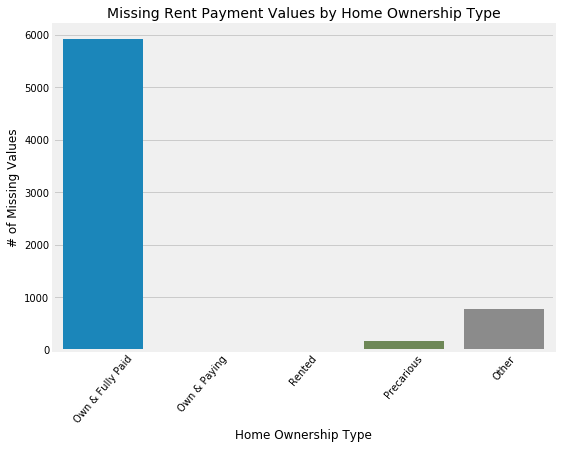

In [10]:
# Create new dataset with count of NaN values and types of home ownership
ownership_type = ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']
ownership_data = train.loc[train['v2a1'].isnull(), ownership_type].sum()
ownership_data = ownership_data.reset_index()

# Plot distribution 
f, ax = plt.subplots(figsize=(8, 6))
plot = sns.barplot(x = 'index', y = 0 , data = ownership_data)
plt.title('Missing Rent Payment Values by Home Ownership Type', fontsize=14)
plt.xlabel('Home Ownership Type', fontsize=12)
plt.ylabel('# of Missing Values', fontsize=12)
plt.xticks([0, 1, 2, 3, 4],
           ['Own & Fully Paid', 'Own & Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 50)
plt.show()

It looks like my hypothesis was correct! From our above graph, we can see that the vast majority of people missing the rent payment value own and have fully paid off their houses which is great. We can go ahead and change those values to 0.

In [11]:
# Change rent payment values to 0
train.loc[(train['tipovivi1'] == 1), 'v2a1'] = 0

For the rest of the missing values that can't be explained by home ownership, there doesn't seem to be a good reason for why they're missing. As a result, we're going to fill in these values with the median value of the dataset. 

In [12]:
# Fill in rest of missing values with median of head of households
train['v2a1'] = train.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

**`v18q1` Number of Tablets**

This one should be relatively easy. We just need to check and make sure that our hypothesis is correct by checking the `v18q` column. This column indicates whether or not a family owns a tablet. So if they have a NaN value in `v18q1`, they should have a 0 in the `v18q` column (indicating that they do not own a tablet as **0=no**).

In [13]:
# Calculate how many null values for those who do and don't own tablets
train.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    7342
1       0
Name: v18q1, dtype: int64

Well that solves that! There aren't any NaN values that we can't explain, so we're just going to replace any of these NaN values in our number of tablets column with 0.

In [14]:
# Replace NaNs with 0 for number of tablets
train.v18q1 = train.v18q1.fillna(0)

**`rez_esc` Years Behind in School**

Now it's time to fix the missing values found in the `rez_esc` column. Once again, after looking in the Kaggle discussion, it looks like this only applies to students who are in school, so we can safely assume that anyone over 19 should not have a value here because they are no longer in school. So for anyone over 19 and younger than 7 with missing values, we can change those numbers to 0. 

In [15]:
# Anyone older than 18 and younger than 7 with missing values gets filled in with a 0
train.loc[((train['age'] >= 19) | (train['age'] < 7)) & (train['rez_esc'].isnull()), 'rez_esc'] = 0

For the rest of the missing values, we'll take a similar approach to filling them in as we did with other non-random missing values above by filling in the missing values with the median of their age group. 

In [16]:
# Fill in remaining NaN values in rez_esc with mean
train['rez_esc'] = train.groupby('age')['rez_esc'].transform(lambda x: x.fillna(x.median()))

**`meaneduc` Mean Education for Adults** & **`SQBmeaned` Square of Meaned**

The last thing we need to do is figure out the missing values in the education columns. `meaneduc` and `SQBmeaned` are correlated (`SQBmeaned` is just the `meaneduc` squared), so we're going to look at them together to try and determine if there's any reason for why there may be missing data. We're going to display the rows with missing data to see if we can make any discoveries of non-random reasons why the data would be missing.

In [17]:
# Display rows with missing values in education columns
train.loc[(train['meaneduc'].isnull()) & (train['SQBmeaned'].isnull())]

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
1291,0.0,0,7,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,10,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,8.0,0,10,NaN,0,0,0,1,0,0,0,0,0,5,0.2,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,18,100,324,1,0,1,0.04,64.0,NaN,324,4
1840,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,6,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,2,8.0,4,0,NaN,0,0,1,0,0,0,0,0,0,1,2.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,36,324,4,16,4,4.00,64.0,NaN,324,4
1841,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,4,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,8.0,4,0,NaN,0,1,0,0,0,0,0,0,0,1,2.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,16,324,4,16,4,4.00,64.0,NaN,324,4
2049,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,0.0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,8.0,12,0,NaN,0,0,0,0,0,0,1,0,0,2,1.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.00,64.0,NaN,361,4
2050,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,0.0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,2,8.0,12,0,NaN,0,0,0,0,0,0,1,0,0,2,1.0,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.00,64.0,NaN,361,4


As far as I can tell, there isn't anything non-random that would explain why these values are missing, so we can go ahead and fill them in. Once again, we'll take a similar approach to filling them in as we did with other non-random missing values above by filling in the missing values with the median. The next question is how will we determine the most accurate median? I think what makes the most sense is to group by years of schooling and fill in the missing values with the median of the group.

In [18]:
# Fill in NaN values in meaneduc with mean
train['meaneduc'] = train.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))

# Fill in NaN values in SQBmeaned with mean
train['meaneduc'] = train.groupby('escolari')['SQBmeaned'].transform(lambda x: x.fillna(x.median()))

Now that we've filled in all of our missing values, it's time to correct any outliers. 

### Clean Test Data

Now that our training dataset has been cleaned, we will need to do all of the same cleaning on our test dataset. We will go ahead and do that now. 

In [19]:
# Change rent payment values to 0
test.loc[(test['tipovivi1'] == 1), 'v2a1'] = 0

# Fill in rest of missing values with median of head of households
test['v2a1'] = test.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

# Replace NaNs with 0 for number of tablets
test.v18q1 = test.v18q1.fillna(0)

# Anyone older than 18 and younger than 7 with missing values gets filled in with a 0
test.loc[((train['age'] >= 19) | (test['age'] < 7)) & (test['rez_esc'].isnull()), 'rez_esc'] = 0

# Fill in remaining NaN values in rez_esc with mean
test['rez_esc'] = test.groupby('age')['rez_esc'].transform(lambda x: x.fillna(x.median()))

# Fill in NaN values in meaneduc with mean
test['meaneduc'] = test.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))

# Fill in NaN values in SQBmeaned with mean
test['meaneduc'] = test.groupby('escolari')['SQBmeaned'].transform(lambda x: x.fillna(x.median()))

In [20]:
# Replace strings with binary
categ_colz = ['dependency', 'edjefe', 'edjefa']
for col in categ_colz:
    test.loc[(test[col] == 'yes'), col]=1
    test.loc[(test[col] == 'no'), col]=0
test[categ_cols] = test[categ_cols].apply(pd.to_numeric)

In [21]:
# Drop Id column
test = test.drop('Id', axis = 1)
test = test.drop('idhogar', axis = 1)

In [22]:
# Drop any remaining NaN values that may have slipped through the cracks
train = train.dropna()
test = test.dropna()

### Outliers

In terms of outliers, I looked into the training and test datasets, it turned out there is only one outlier value `rez_esc` in test set which is a value of 99 even though the highest possible value is 5. This is obviously an outlier and an incorrect value that needs to be corrected. Acorrding to this [answer](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403) from competition host, we can safely change the value to 5 as that is the maximum value for that variable. 

In [23]:
# Change outlier to 5
test[['rez_esc'] == 99.0 , 'rez_esc'] = 5

### Feature Engineering

Our training and test datasets have been cleaned, and now it is time to do a bit of feature engineering. Feature engineering involves creating entirely new variables from our existing data. This will help our model to perform better by adding variables that will help it to predict poverty even better. 

The first variable that I think would be valuable to add is some sort of variable that takes into account all of the features of the house. The variables we have identified that are features of a house are:
- `cielorazo` if house has ceiling
- `epared1` walls bad, `epared2` walls regular, `epared3` walls good
- `etecho1` roof bad, `etecho2` roof regular, `etecho3` roof bad
- `eviv1` floor bad, `eviv2` floor regular, `eviv3`floor bad

For the walls, floor, and roof variables, we are going to create some new ordinal variables to simplify things and then drop the old variables. 

In [24]:
# Create wall ordinal variable
train['walls'] = np.argmax(np.array(train[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# Drop old wall variables
train = train.drop(columns = ['epared1', 'epared2', 'epared3'])

# Create roof ordinal variable
train['roof'] = np.argmax(np.array(train[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)

# Drop old roof variables
train = train.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Create floor ordinal variabletrain
train['floor'] = np.argmax(np.array(train[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)

# Drop old floor variables
train = train.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

Now that we have created ordinal variables for the family's walls, floor, and roof, we can go ahead and construct a new variable that is a combination of the three. This will allow us to have a sort of home quality score for each household. In addition to these new ordinal variables, we will also add the following home features to `homeScore`:
- `cielorazo`
- `energcocinar2`
- `energcocinar3`
- `abastaguadentro`
- `paredblolad`
- `pisomoscer`

In [25]:
# Create new variable homeScore by adding our three new ordinal variables together and other home features
train['homeScore'] = train['walls'] + train['roof'] + train['floor'] + 2*train['cielorazo'] + 2*train['energcocinar2'] + train['energcocinar3'] + train['abastaguadentro'] + train['paredblolad'] + train['pisomoscer']

Now we have a `homeScore` variable, but I think there are some other features that may be helpful in predicting poverty level. Let's go ahead and create a similar feature for technology by creating a `techScore` variable. The features we will be including in `techScore` are:
- `v18q`
- `computer`
- `mobilephone`
- `television`
- `refrig`

Each of these features will give a point to their tech score. 

In [26]:
# Create new variable techScore by adding our tech variables together
train['techScore'] = (train['v18q'] + train['computer'] + train['mobilephone'] + train['refrig']
                      + train['television'] )

Hopefully these `homeScore` and `techScore` variables will be helpful in predicting poverty level. We can go ahead and check if they will be helpful by analyzing our target and determining the correlation of all the variables. But before we do that, we're gonna go ahead and create these new variables in our test data as well. 

In [27]:
# Perform feature engineering on test dataset

# Create wall ordinal variable
test['walls'] = np.argmax(np.array(test[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

# Drop old wall variables
test = test.drop(columns = ['epared1', 'epared2', 'epared3'])

# Create roof ordinal variable
test['roof'] = np.argmax(np.array(test[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)

# Drop old roof variables
test = test.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Create floor ordinal variabletrain
test['floor'] = np.argmax(np.array(test[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)

# Drop old floor variables
test = test.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

# Create new variable homeScore by adding our three new ordinal variables together
test['homeScore'] = test['walls'] + test['roof'] + test['floor'] + 2*test['cielorazo'] + 2*test['energcocinar2'] + test['energcocinar3'] + test['abastaguadentro'] + test['paredblolad'] + test['pisomoscer']

# Create new variable techScore by adding our tech variables together
test['techScore'] = (test['v18q'] + test['computer'] + test['mobilephone'] + test['refrig']
                      + test['television'] )

### Analyze the Target

Now that our data has been cleaned and we've done a bit of feature engineering, the next thing that we want to do is identify and analyze the target. In this case, our target is the `Target` column (which represents the poverty level on a scale from 1-4) as it is the variable that we will be trying to predict.

In [28]:
# Descriptive summary of Target data
target = train['Target']
target.describe()

count    9376.000000
mean        3.302154
std         1.010399
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: Target, dtype: float64

We will also set apart our target variable `heads` which will be the poverty level of the head of household. This is the poverty level that we are trying to predict.

In [29]:
# Creating variable heads for poverty level of heads of households
heads = train.loc[(train['parentesco1']==1), 'Target']

The next thing we'll want to do is get an idea of the distribution of the `Target` classes. This will be helpful in understanding how balanced our data are. 

([<matplotlib.axis.XTick at 0x223ae5dc048>,
 <a list of 4 Text xticklabel objects>)

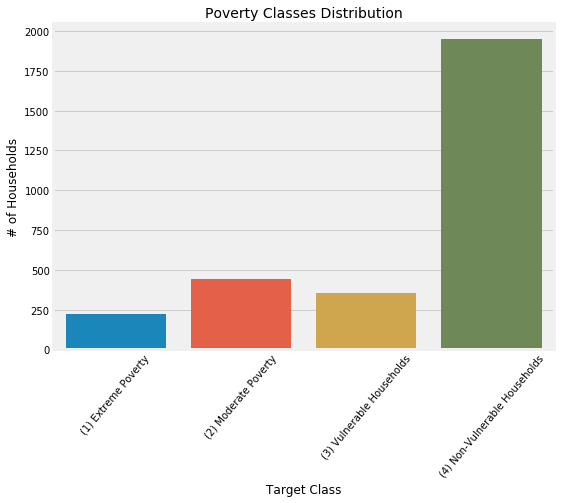

In [30]:
# Display the distribution of our target variable classes
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(heads)
plt.title('Poverty Classes Distribution', fontsize=14)
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('# of Households', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['(1) Extreme Poverty', '(2) Moderate Poverty', '(3) Vulnerable Households', '(4) Non-Vulnerable Households'],
          rotation = 50)

From a social perspective this distribution is great as the number of "non-vulnerable" households dwarf the remaining three classes, however it is not an ideal distribution for machine learning purposes because it is so imbalanced. Imbalanced data is not ideal because it is difficult for our models to predict minority classes since they don't get to see many examples of them in comparison to the "non-vulnerable" class. We will address this problem later on. 

#### Correlation Heatmap

The next way we are going to analyze our target variable is by identifying which variables have the highest correlation with it. This will help us to determine which variables are the most important in helping to predict the target variable. Because we have so many variables, we are only going to display the variables with the highest correlation. 

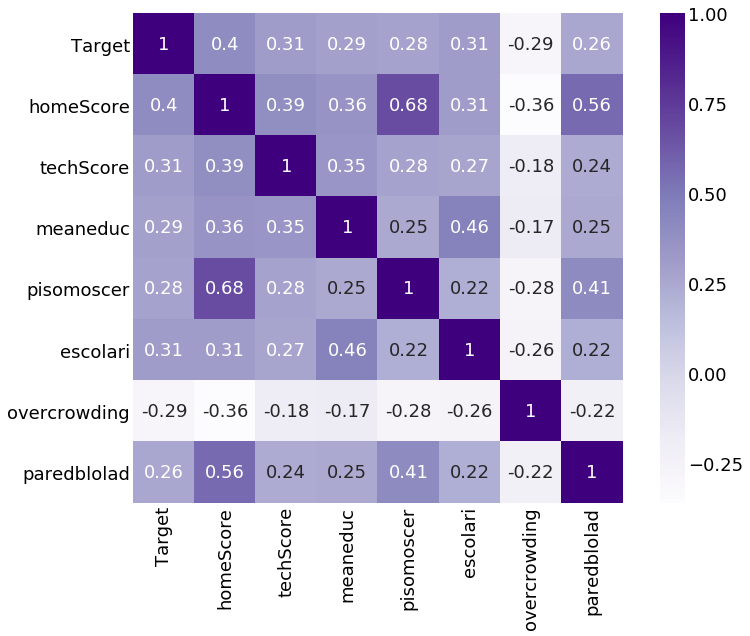

In [31]:
# Create array with the most predictive variables
v = ['Target', 'homeScore', 'techScore', 'meaneduc',
             'pisomoscer', 'escolari', 'overcrowding', 'paredblolad']

# Calculate the correlations
corrm = train[v].corr().round(2)

# # Create a Target variable heatmap
plt.rcParams['font.size'] = 18
plt.figure(figsize = (12, 9))
sns.heatmap(corrm, cbar=True, annot=True, square=True, yticklabels=v, xticklabels=v, cmap="Purples");

In the above heatmap, we can see the correlation between our prediction variables and our target variable. The good news is that our `homeScore` and `techScore` variables we created are outperforming the rest of our prediction variables. This means all that feature engineering was worth it!

Now let's create some point plots between poverty level and these highly correlated variables to see what we can learn.

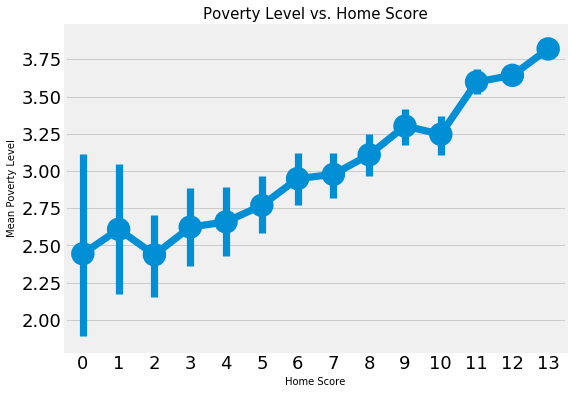

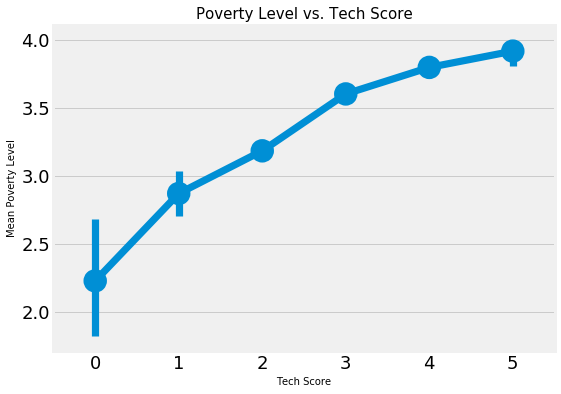

In [32]:
# Use pointplot to see the relationship between the target variable and our homeScore and techScore variables
f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x = train['homeScore'], y = heads)
plt.xlabel('Home Score', fontsize=10)
plt.ylabel('Mean Poverty Level', fontsize=10)
plt.title('Poverty Level vs. Home Score', fontsize=15)
plt.show();

f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x = train['techScore'], y = heads)
plt.xlabel('Tech Score', fontsize=10)
plt.ylabel('Mean Poverty Level', fontsize=10)
plt.title('Poverty Level vs. Tech Score', fontsize=15)
plt.show();

The above graphs show that, as we expected, as poverty increases, our  `homeScore` and `techScore` increase as well. 

Let's take a closer look at the distributions of our `homeScore` and `techScore` variables we've created. 

Text(0,0.5,'Mean Poverty Level')

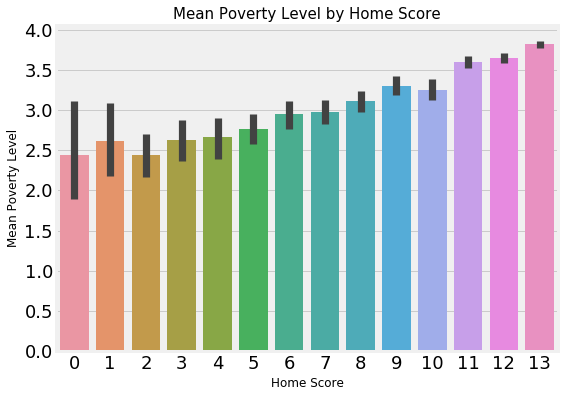

In [33]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x = 'homeScore', y = heads, data = train)
plt.title('Mean Poverty Level by Home Score', fontsize=15)
plt.xlabel('Home Score', fontsize=12)
plt.ylabel('Mean Poverty Level', fontsize=12)

Text(0,0.5,'Mean Poverty Level')

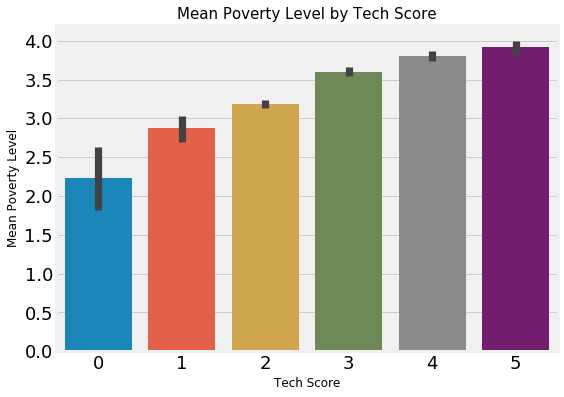

In [34]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x = 'techScore', y = heads, data = train)
plt.title('Mean Poverty Level by Tech Score', fontsize=15)
plt.xlabel('Tech Score', fontsize=12)
plt.ylabel('Mean Poverty Level', fontsize=12)

For the most part, this is exactly what we wanted to see. As families have a higher quality home or more technology, they are for the most part more wealthy and not in danger of living in poverty. These should be very helpful when it comes to predicting poverty level. 

Now let's look at at a couple violin plots to get an understanding of the distribution of education, home score, and tech score. Violion plots are helpful as they show the distribution of quantitative data across several classes which is perfect for our data. 

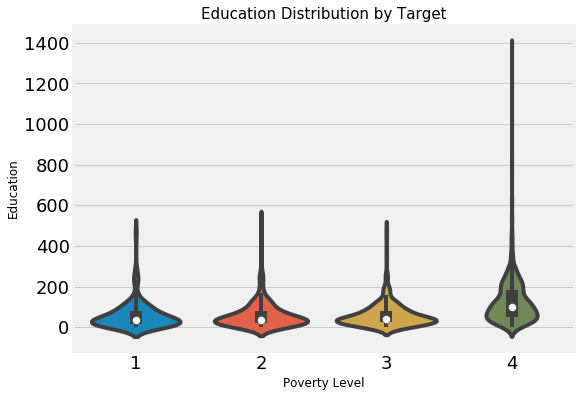

In [35]:
plt.figure(figsize = (8, 6))
sns.violinplot(x = heads, y = 'meaneduc', data = train);
plt.ylabel('Education', fontsize=12)
plt.xlabel('Poverty Level', fontsize=12)
plt.title('Education Distribution by Target', fontsize=15);

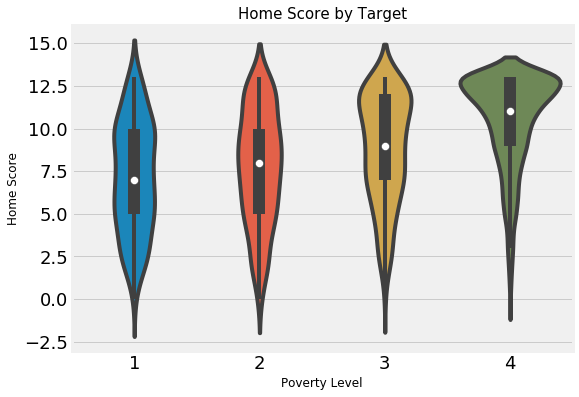

In [36]:
plt.figure(figsize = (8, 6))
sns.violinplot(x = heads, y = 'homeScore', data = train);
plt.ylabel('Home Score', fontsize=12)
plt.xlabel('Poverty Level', fontsize=12)
plt.title('Home Score by Target', fontsize=15);

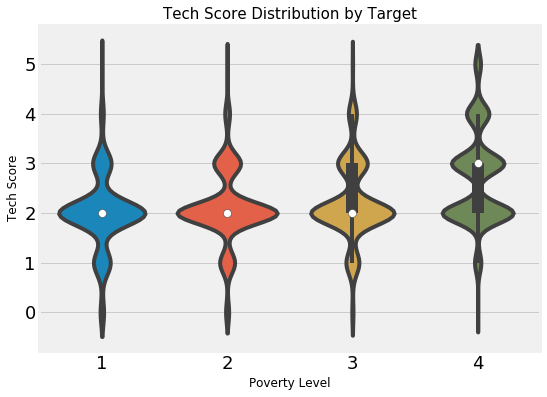

In [37]:
plt.figure(figsize = (8, 6))
sns.violinplot(x = heads, y = 'techScore', data = train);
plt.ylabel('Tech Score', fontsize=12)
plt.xlabel('Poverty Level', fontsize=12)
plt.title('Tech Score Distribution by Target', fontsize=15);

These violin plots are somewhat helpful as they show that our predictor variables may not be perfect. There seems to be quite a lot of crossover in where the majority of the distribution lies especially with education (although class 4 aka the wealthy has a very long whisker coming out of the top).

Now we can do a bit more visualization of our predictor variables by looking at the relationship between poverty level and `cielorazo` which is whether or not the house has a cieling. This variable is included in our `homeScore` but may be interesting to look at regardless. 

Text(466.533,0.5,'Count')

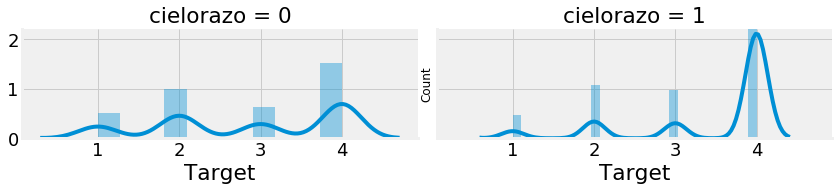

In [38]:
# Use pointplot to see the relationship between the target variable and cielorazo
plot = sns.FacetGrid(data = train, col ='cielorazo', aspect=2, margin_titles = True)
plot.map(sns.distplot, 'Target')
plt.ylabel('Count', fontsize=12)

Here we can see the distributions of poverty levels of families who have homes with a roof (cielorazo = 1) vs. families without one (cielorazo = 0). It is obvious to see that families who have a roof on their home are in general much better off. 

Now let's look at one more pointplot to look closer at the relationship between the target variable and years of education. 

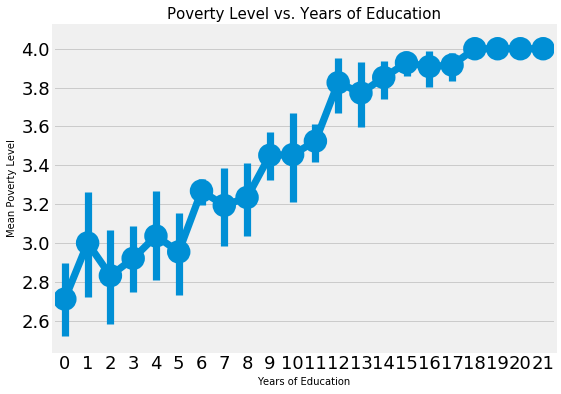

In [39]:
# Use pointplot to see the relationship between the target variable and years of education
f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x = train['escolari'], y = heads)
plt.xlabel('Years of Education', fontsize=10)
plt.ylabel('Mean Poverty Level', fontsize=10)
plt.title('Poverty Level vs. Years of Education', fontsize=15)
plt.show();

Once again, as we expect, as years of education increases, we see their poverty level decrease (or increase in terms of our classes).

### Model Fitting & Evaluation

Now that we've analyzed our target variable and looked closer at how our variables that are correlated with poverty level, it's time to build our models. The goal is to use machine learning techniques to learn from our training data the relationship between a set of variables and our target variable (which we want to predict).

In order to determine which of our models is the best, we need to decide on a metric that we will use to evaluate all of our models. As opposed to regression models that are evaulated on mean squared error (MSE), with classification problems we will be evaluating our models based on an F1 score. It is the harmonic mean of precision and recall. The harmonic mean is used because it tends strongly towards the smallest element being averaged. If either precision or recall is 0 then your F1 is zero. The best F1 score is one.

But first, we are going to drop our target variable from our training set and are going to implement a train/test split.  By splitting the data into a training set and a test set, we can improve our F1 results. 

In addition to improving our F1 score, the train/test split should also help to avoid any over-fitting of our data.

In [40]:
# First we need to drop our Target variable from the training set
train = train.drop(['Target'], axis = 1).reset_index(drop = True)

# Only keep columns in test that are also found in train
train = train.reindex(columns = test.columns, fill_value=0)

In [42]:
# Splitting the data into two datasets (training and test)
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.20, random_state=42)

#### Cross Validation Baseline

Before we do anything else, I'd like to quickly run a few different models to get an idea of what our F1 score will be with each one using cross validation. Once we've done that, we can go through one by one, dig in a littler deeper, and tune the hyper-parameters for each one. 

In [44]:
# Create function to cross validate our models
def test_clf(clf):
    score = cross_val_score(clf, train, target, scoring = 'f1_macro', cv = 10)
    print(clf.__class__.__name__,"Score =", score.mean())

In [45]:
# Run a few models we will be testing 
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svc = SVC()
gnb = GaussianNB()

models = [rf, knn, svc, gnb]
for clf in models:
    test_clf(clf)

RandomForestClassifier Score = 0.3333095011609159
KNeighborsClassifier Score = 0.3271666464877413
SVC Score = 0.2052294802609921
GaussianNB Score = 0.36829000972334536


Of these models that I ran, GaussianNB and Random Forest outperformed the SVC and K-Nearest Neighbors. This is helpful because now we have an idea of which models might be best suited for our poverty classification problem. 

### Fix Imbalanced Data

Before we go on to hypertuning our models, let's go ahead and deal with our imbalanced data issue. In order to fix this problem of imbalanced data, we are going to use the method of oversampling. 

Oversampling is a technique that can be used to handle inbalanced data. What oversampling does is it shows our model more examples of the minority classes (1-3 on our poverty scale) in order to help it to do a better job of predicting this under-represented classes. 

In [46]:
# Create new training sets with oversampling
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_sample(X_train, y_train)

Let's see if the oversampling worked by showing our new distribution of the resampled training data.

Text(0.5,0,'Poverty Level')

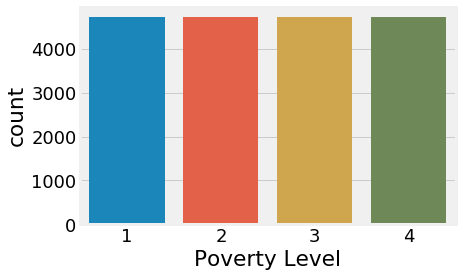

In [47]:
# Display resampled training data
sns.countplot(y_res)
plt.xlabel('Poverty Level')

Nice! Looks like it worked perfectly. 

Now let's go ahead and create a function that will evaluate our models. This function, evaluation_metrics, returns the accuracy, precision, recall, and f1 metrics for both the train and test set.

In [48]:
# Create function to evaluate models
def evaluation_metrics(y_res, y_test, train_predictions, test_predictions):
    rounding = 2
    print('Accuracy:')
    print("  Train: {}".format(round(accuracy_score(y_res, train_predictions),rounding)), "  Test: {}".format(round(accuracy_score(y_test, test_predictions),rounding)))

    print('Precision:')
    print("  Train: {}".format(round(precision_recall_fscore_support(y_res, train_predictions, average=None)[0][0],rounding)), "  Test: {}".format(round(precision_recall_fscore_support(y_test, test_predictions)[0][0],rounding)))

    print('Recall:')
    print("  Train: {}".format(round(precision_recall_fscore_support(y_res, train_predictions, average=None)[1][0],rounding)), "  Test: {}".format(round(precision_recall_fscore_support(y_test, test_predictions)[1][0],rounding)))

    print('F1:')
    print("  Train: {}".format(round(precision_recall_fscore_support(y_res, train_predictions,  average=None)[2][0],rounding)), "  Test: {}".format(round(precision_recall_fscore_support(y_test, test_predictions)[2][0],rounding)))

We have our new oversampled data and our function for evaluating models we created. Let's get to hypertuning our models! The first model we'll start with is a basic logistic classifier. We'll use this as a sort of baseline.

#### Logistic Classifier

The logistic classifier starts with a cost function, calculates gradients (the logistic cost function is convex and has a single global minimum) and then uses a gradient descent algorithm to determine coefficient values that minimize the defined cost function. 

In [49]:
# Fit a model with the default penalty, l2
lr = linear_model.LogisticRegression(penalty='l2')
lr.fit(X_res, y_res)
lr_train_predictions = lr.predict(X_res)
lr_test_predictions = lr.predict(X_test)

In [50]:
# Print evaluation metrics
evaluation_metrics(y_res, y_test, lr_train_predictions, lr_test_predictions)

Accuracy:
  Train: 0.48   Test: 0.58
Precision:
  Train: 0.47   Test: 0.26
Recall:
  Train: 0.56   Test: 0.59
F1:
  Train: 0.51   Test: 0.36


Could be worse! Our first model achieved 58% accuracy and an F1 score of .36. Our precision wasn't great as it was only 26%. The good news is our oversampling has already helped a bit with our F1 score. Let's see if we can beat it!

#### K-Nearest Neighbors

The next model we'll try out is K-nearest neighbors. K-nearest neighbors is a model that looks at a datapoints closest neighbors in order to predict what class it most likely is. The K refers to how many neighbors to consider when classifying a new data point.

As a reminder, here are the steps of k-nearest neighbors:

- Define k (where a high value of k has more bias, and a low k has more variance)
- Define a distance metric (usually Euclidean distance)
- For a new data point, find the k nearest training points and combine the classes in some way, usually voting, to get a predicted class.

In [68]:
# Create K-nearest neighbors model 
param_dist = {"n_neighbors": [5, 7, 9, 11], "weights": ['distance'], 'p': [1, 2, 3]}
model = KNeighborsClassifier()
knn = GridSearchCV(model, param_grid = param_dist, scoring='f1_macro')
knn.fit(X_res, y_res)
knn_train_predictions = knn.predict(X_res)
knn_test_predictions = knn.predict(X_test)
print("Best Params: {}".format(knn.best_params_))

Best Params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}


In [69]:
# Print evaluation metrics
evaluation_metrics(y_res, y_test, knn_train_predictions, knn_test_predictions)

Accuracy:
  Train: 1.0   Test: 0.5
Precision:
  Train: 1.0   Test: 0.28
Recall:
  Train: 1.0   Test: 0.43
F1:
  Train: 1.0   Test: 0.34


Our K-Nearest Neighbors model hasn't performed quite as well in terms of F1 score as our baseline Linear regression. We didn't expect it to do terribly well given our cross validation screen above, so we'll move on to Naive Bayes. 

#### Naive Bayes

Bayes theorem allows us to go from a prior and sampling distribution to a posterior distribution, where the sampling distribution is the probability of seeing our data given our parameters. We want the posterior, or the probability of our parameters given our data and are typically given data and want to figure out what parameters are most likely given our data.

With that background about Bayes Theorem in mind, Naive Bayes basically calculates the probability of one of our classes given our data. The prior is easy to calculate (its just the probability of being in that class as seen in the training data). In this case, we'll use the Gaussian distribution as our likelihood.

In [53]:
# Gaussian Naive Bayes 
nb = GaussianNB()
nb.fit(X_res, y_res)
nb_train_predictions = nb.predict(X_res)
nb_test_predictions = nb.predict(X_test)

In [54]:
# Print evaluation metrics
evaluation_metrics(y_res, y_test, nb_train_predictions, nb_test_predictions)

Accuracy:
  Train: 0.42   Test: 0.5
Precision:
  Train: 0.5   Test: 0.29
Recall:
  Train: 0.36   Test: 0.42
F1:
  Train: 0.42   Test: 0.34


It looks like our Naive Bayes model has gotten us the same exact F1 score as the above K-nearest neighbors mode with a score of .34. In this case, it looks like the oversampling may have only helped a marginal amount. 

#### Decision Tree

Decision trees are very intuitive and easy to understand.  Once you have a tree, you just follow the forks down for your example to get to an end node. Then at that end node you take the most common class or average value for regression. In fact, with classification you can get probabilistic estimates by taking the fraction of examples in that class.

Some pros of decision trees:
- easy to explain
- can be visualized
- can handle categorical variables and missing data well

Some cons of decision trees:
- typically don't have very strong prediction accuracy 
- very sensitive to small changes in training data

Let's try it out!

In [55]:
# Creating decision tree model
param_dist = {"max_depth":[3,5,7], "criterion": ['gini', 'entropy']}
model = DecisionTreeClassifier()
dt = GridSearchCV(model, param_grid = param_dist, scoring='f1_macro')
dt.fit(X_res, y_res)
dt_train_predictions = dt.predict(X_res)
dt_test_predictions = dt.predict(X_test)
print("Best Params: {}".format(dt.best_params_))

Best Params: {'criterion': 'entropy', 'max_depth': 7}


In [56]:
# Print evaluation metrics
evaluation_metrics(y_res, y_test, dt_train_predictions, dt_test_predictions)

Accuracy:
  Train: 0.57   Test: 0.53
Precision:
  Train: 0.57   Test: 0.28
Recall:
  Train: 0.71   Test: 0.66
F1:
  Train: 0.64   Test: 0.39


Our decision tree got us an F1 score of .39 which isn't great, but it's the best so far! Let's keep on going. 

#### Random Forest

The fundamental idea of a random forest model is that combining weak learners (decision trees) can led to a strong learner (random forests). It is an ensemble model, meaning that a group of models are used together to make a prediction. The cost of doing so is the ability to interpret the model. Also, we would like each of the trees to be as varied as possible; if they are very correlated then we do not gain much.

In [57]:
# Create Random Forest Model
clf = RandomForestClassifier(n_estimators=1000, max_depth=10)
clf.fit(X_res, y_res)
test_predictions = clf.predict(X_test)
print("Test Classification Report:")
print(classification_report(y_test, test_predictions))

Test Classification Report:
             precision    recall  f1-score   support

          1       0.64      0.85      0.73       151
          2       0.74      0.76      0.75       322
          3       0.64      0.84      0.72       236
          4       0.95      0.84      0.89      1167

avg / total       0.85      0.83      0.83      1876



Look at that! Our random forest model has performed quite well compared to everything else. Our average F1 score was **.83** which is a huge improvement since we fixed our imbalanced data. 

### Model Interpretation 

Overall, our Random Forest model was the best at predicting our target variable, poverty level. Let's go ahead and take a closer look at what is driving our predictions in this model.

In [58]:
# Fit model using 'best' parameters from above
rff = RandomForestClassifier(n_estimators = 1000, max_depth = 10)
rff.fit(X_train, y_train)

# Determine feature importance
feature_imp = sorted(list(zip(train.columns, rff.feature_importances_)), key=lambda x: x[1], reverse=True)

# Narrow it down to top 12 features
feature_imp = feature_imp[0:12]

Text(0.5,1,'Most Predictive Features in Resampled Random Forest Model')

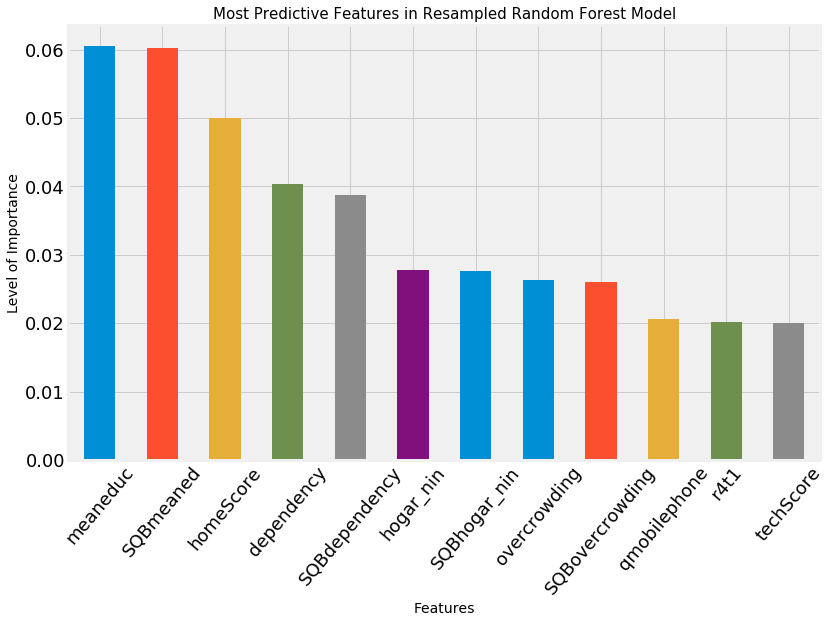

In [66]:
# Plot the top 12 features
f, ax = plt.subplots(figsize=(12,8))
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')
plt.ylabel('Level of Importance', fontsize=14)
plt.xlabel('Features', fontsize=14)
plt.xticks(rotation = 50)
plt.title('Most Predictive Features in Resampled Random Forest Model', fontsize=15)

In the above bar graph, we can see the twelve most important predictor variables to our random forest model. It is nice to see that our `homeScore` and `techScore` variables we created both made the top 12 -- our feature engineering helped! Another interesting thing to note is I've run this model a few times and because it is a random forest, these bars do change slightly every time. But the changes aren't drastic, just slight differences caused by the randomness of the model. 

### Model Graveyard

Unfortunately, two of the models that I tried, SVM and Gradient Boosting, were too much for my machine to handle. I've included them below despite not having any evaluation metrics to learn from.

#### SVM

SVM chooses a hyperplane to separate the classes, implying that we only care about data points from each class that are closest to the separating hyperplane. These points are called support vectors. Hence the name of the model, support vector machine. With a soft-margin classifier, the trick is finding a balance between a max-margin classifier and limiting the number of margin violations, which are the data points that fall on the wrong side of the hyperplane.

In [ ]:
# SVM 
param_dist = {"C": [0.2, 0.5, 0.7], "kernel": ['linear', 'poly', 'rbf'], 'degree': [1,2,3]}
model = SVC()
svm = GridSearchCV(model, param_grid = param_dist, scoring='f1_macro')
svm.fit(X_res, y_res)
svm_train_predictions = svm.predict(X_res)
svm_test_predictions = svm.predict(X_test)
print("Best Params: {}".format(svm.best_params_))

In [ ]:
# Print evaluation metrics
evaluation_metrics(y_res, y_test, svm_train_predictions, svm_test_predictions)

Unfortunately, my machine couldn't handle trying to tune this model :( so we're going to have to just refer to it's initial cross validation score above which was an f1 score of .2 which was the worst of the models we tried. 

#### Gradient Boosting

Boosting is an ensemble technique like random forests. With random forests, decision trees are trained independently and create independence by randomly sampling samples and features. Boosting trains multiple models sequentially where each each model tries to improve on the areas where the previous models performed poorly.

In [ ]:
# Gradient Boosting model
clf = GradientBoostingClassifier()
gridsearch = GridSearchCV(clf, {"learning_rate": [.1, .01, .001], "n_estimators": [100, 1000, 5000], 'max_depth': [1, 2, 3]}, scoring='f1_macro')
gridsearch.fit(X_res, y_res)

In [ ]:
# Print evaluation metrics
print("Best Params: {}".format(gridsearch.best_params_))
print("\nClassification Report:")
print(classification_report(y_test, gridsearch.predict(X_test)))

Once again, my machine couldn't handle the gradient boosting model. It's a bummer because I really wanted to see how it would fare compared to the Random Forest model. Oh well!

### Conclusion

That's it! We've fit five or so different models to predict the level of poverty of households in Costa Rica. 

In conclusion, throughout this notebook we introduced to the problem of Costa Rican poverty classification, then explored the dataset, cleaned the dataset, worked on feature engineering, tried out multiple machine learning models, optimized the models, and have concluded that our Random Forest model was the best at predicting Costa Rican poverty levels with an F1 score of .83. It's far from perfect, but I think it does a decent enough job to be helpful to those who are trying to determine who needs aid the most. 

#### Sources:
- Data: [Costa Rican Household Poverty Level Prediction (Kaggle)](https://www.kaggle.com/c/costa-rican-household-poverty-prediction)
- Tyler's Lectures: [Naive Bayes](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_7_Naive_Bayes.ipynb),
[SVM](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_8_SVM.ipynb),
[Decision Tree](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_9_Decision_Trees.ipynb), [Random Forest](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_10_Random_Forest.ipynb), [Boosting](https://github.com/tfolkman/byu_econ_applied_machine_learning/blob/master/lectures/Lecture_11_Boosting.ipynb)
- Helpful Kernal: [A Complete Itroduction and Walkthrough (Kaggle)](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough)